# Tensor Flow

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import pickle
import numpy as np
import matplotlib.pyplot as plt

## Model

In [151]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 126, 126, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_104 (Conv2D)         (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 30, 30, 32)     

In [152]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=tf.keras.losses.MeanSquaredError(),)

## Import data

In [133]:
with open('labeled_data/sources_0.obj', 'rb') as f:
    sources = pickle.load(f)

First time I tried 80 as the training size, that seemed to work well, but I haven't been able to replicate that early success...

In [134]:
trainingSize = 60
testSize = len(sources)-1 - trainingSize

In [135]:
train_images = np.empty((trainingSize, 256, 256, 3), dtype=np.float32)
train_labels = np.empty((trainingSize, 4), dtype=np.float32)
test_images = np.empty((testSize, 256, 256, 3), dtype=np.float32)
test_labels = np.empty((testSize, 4), dtype=np.float32)

For some reason number 99 doesn't work, so I had to only take up to index 98...

In [136]:
randomIndices = np.random.choice(len(sources)-1, len(sources)-1,replace=False)

In [14]:
mySource = sources[randomIndices[0]]

In [15]:
(x0,x1) = (mySource.images[0].x0, mySource.images[0].x1)

In [17]:
np.array([x0,x1],dtype=np.float32)

array([  7., 256.], dtype=float32)

In [137]:
for i in range(trainingSize):
    source = sources[randomIndices[i]]
    images = np.dstack((source.images[0].data, source.images[1].data, source.images[2].data))
    (x0,x1) = (source.images[0].x0, source.images[0].x1)
    (y0,y1) = (source.images[0].y0, source.images[0].y1)
    labels = np.array([x0,x1,y0,y1])
    train_images[i] = images
    train_labels[i] = labels
for i in range(testSize):
    source = sources[randomIndices[i+trainingSize]]
    images = np.dstack((source.images[0].data, source.images[1].data, source.images[2].data))
    (x0,x1) = (source.images[0].x0, source.images[0].x1)
    (y0,y1) = (source.images[0].y0, source.images[0].y1)
    labels = np.array([x0,x1,y0,y1])
    test_images[i] = images
    test_labels[i] = labels

### Data exploration

In [171]:
train_images.flatten()

array([8.1609694e-05, 7.3702974e+00, 6.2177377e+00, ..., 5.6308330e-05,
       7.1440387e+00, 7.7501213e+01], dtype=float32)

Need to get max values from each image set to scale values accordingly.

In [174]:
ind = np.argpartition(train_images.flatten(), -10)[-10:]
print(train_images.flatten()[ind])

[169218.72 169257.69 169447.42 169381.14 169626.42 169652.56 169870.31
 169844.42 169960.44 169769.61]


In [138]:
print("Train: ", train_images.shape)
print("Train Labels: ", train_labels.shape)
print("Test: ", test_images.shape)
print("Test Labels: ", test_labels.shape)

Train:  (60, 256, 256, 3)
Train Labels:  (60, 4)
Test:  (39, 256, 256, 3)
Test Labels:  (39, 4)


## Model Fitting/Training

Below is the normal fitting method. Then I try including a validation dataset. I am concerned that perhaps we simply don't have enough data.

In [123]:
history = model.fit(train_images, train_labels, epochs=50, batch_size=12)

Epoch 1/50
7/7 [==============================] - 0s 16ms/step - loss: 18183.0625
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 17778.7500
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 18841.8867
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 17614.4473
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 17955.5039
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 17418.7715
Epoch 7/50
7/7 [==============================] - 0s 16ms/step - loss: 17429.6094
Epoch 8/50
7/7 [==============================] - 0s 16ms/step - loss: 17061.6367
Epoch 9/50
7/7 [==============================] - 0s 15ms/step - loss: 14606.7686
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - loss: 15539.7090
Epoch 11/50
7/7 [==============================] - 0s 16ms/step - loss: 16176.9141
Epoch 12/50
7/7 [==============================] - 0s 15ms/step - loss: 16512.3496
Epoch 13/50
7

Not entirely sure if it's fine to have the validation data in here below

In [158]:
history = model.fit(train_images, train_labels, epochs=50, batch_size=12, validation_data=(test_images, test_labels))

Epoch 1/50
5/5 [==============================] - 0s 16ms/step - loss: 11034.2354
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 10499.5732
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 11519.2930
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 12345.5938
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 11346.5771
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 10771.8975
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 12833.9414
Epoch 8/50
5/5 [==============================] - 0s 15ms/step - loss: 11087.0225
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 11277.6865
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 11410.8662
Epoch 11/50
5/5 [==============================] - 0s 16ms/step - loss: 11267.6611
Epoch 12/50
5/5 [==============================] - 0s 16ms/step - loss: 10350.3301
Epoch 13/50
5

In [157]:
model.predict(test_images[0:5])

1/1 [==============================] - 0s 14ms/step


array([[ 59.2323  ,  80.742485,  32.232113,  60.9515  ],
       [ 71.461754,  99.43736 ,  40.77785 ,  76.64089 ],
       [ 89.44123 , 119.99587 ,  47.92052 ,  83.32702 ],
       [ 96.7004  , 132.28125 ,  45.192886, 106.40865 ],
       [ 85.22353 , 119.006935,  40.688026,  81.78174 ]], dtype=float32)

In [147]:
test_labels[0:5]

array([[109., 146., 105., 141.],
       [109., 142., 114., 144.],
       [103., 143., 111., 148.],
       [  0., 256.,   0., 256.],
       [116., 142., 113., 143.]], dtype=float32)

In [22]:
model.history.history

dict_keys([])

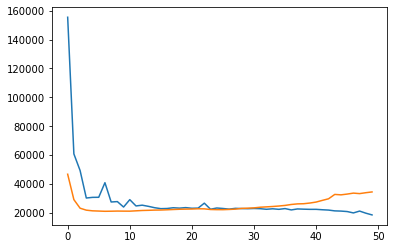

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [126]:
model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 288ms/step - loss: 34160.9492


34160.94921875